In [ ]:
import numpy as np
import os
import scipy
import h5py
import time as clocktime
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder, DictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
#mpl.rc('text', usetex=True)
mpl.rc('font', size=20)
mpl.rc('figure', figsize=(20, 10))
## Load marmousi data sampled every 15 m
fil = h5py.File('marmousi_vel.hdf5', 'r')
vel = fil['velocity'][:].astype(np.float64)
fil.close()
dx = 15.0 # horizontal grid spacing for marmousi model
dz = 15.0 # vertical grid spacing for marmousi model

Z Shape : (189,)
X Shape : (500,)
Z limit : 0.0 to 2820.0
X limit : 7485.0 to 0.0


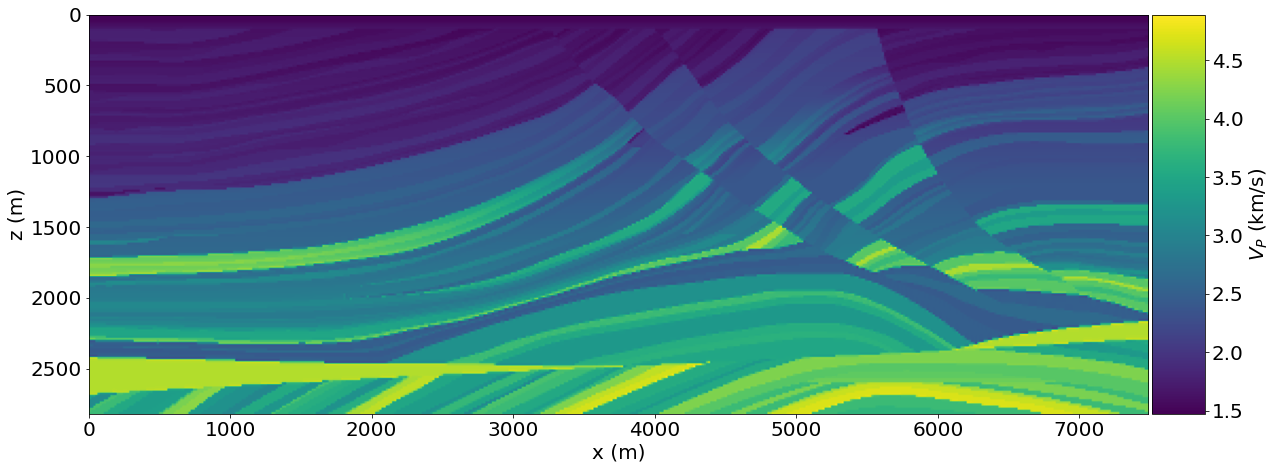

In [ ]:
### convert velocity to time
z = np.arange(vel.shape[1])*dz
x = np.arange(vel.shape[0])*dx

print('Z Shape : '+str(z.shape))
print('X Shape : '+str(x.shape))
print('Z limit : '+str(z[0])+' to '+str(z[-1]))
print('X limit : '+str(x[-1])+' to '+str(x[0]))

plt.figure()
extent = [x[0], x[-1], z[-1], z[0]]
plot=plt.imshow(np.transpose(vel), extent=extent)
plt.xlabel('x (m)')
plt.ylabel('z (m)')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot, cax=cax)
cbar.set_label(r'$V_{P}$ (km/s)')

xv, zv = np.meshgrid(x, z)
tm = 2.0*dz/(1000*vel)
tt = np.cumsum(tm, axis=1)

tmin = np.min(tt.flatten())
tmax = np.max(tt.flatten())

dt=0.002
time = np.arange(0, (tmax+dt), dt)

vel_time=np.zeros([vel.shape[0],time.shape[0]])
for i in range(vel.shape[0]) :
    vel_time[i,:] = scipy.interpolate.griddata(tt[i,:], vel[i,:], time, method='nearest')


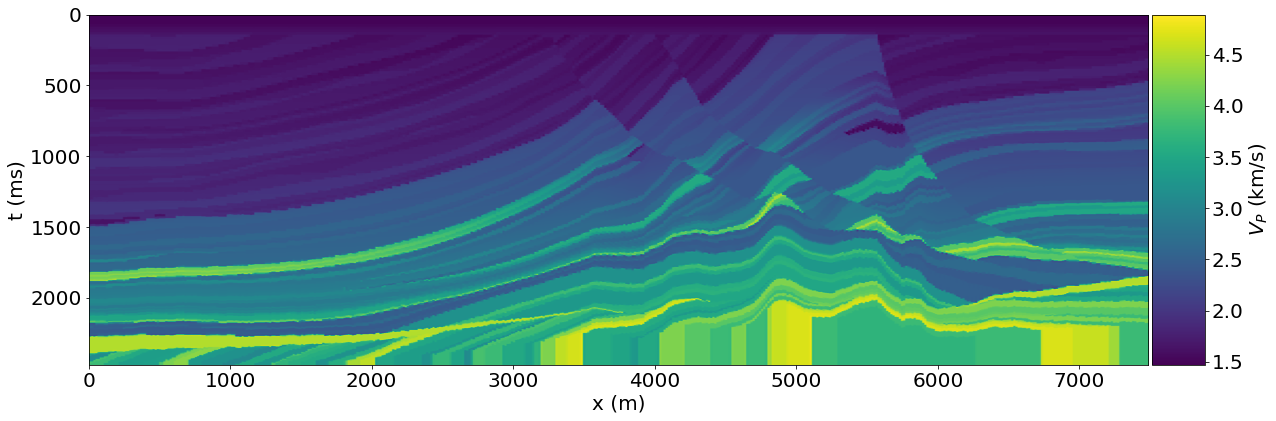

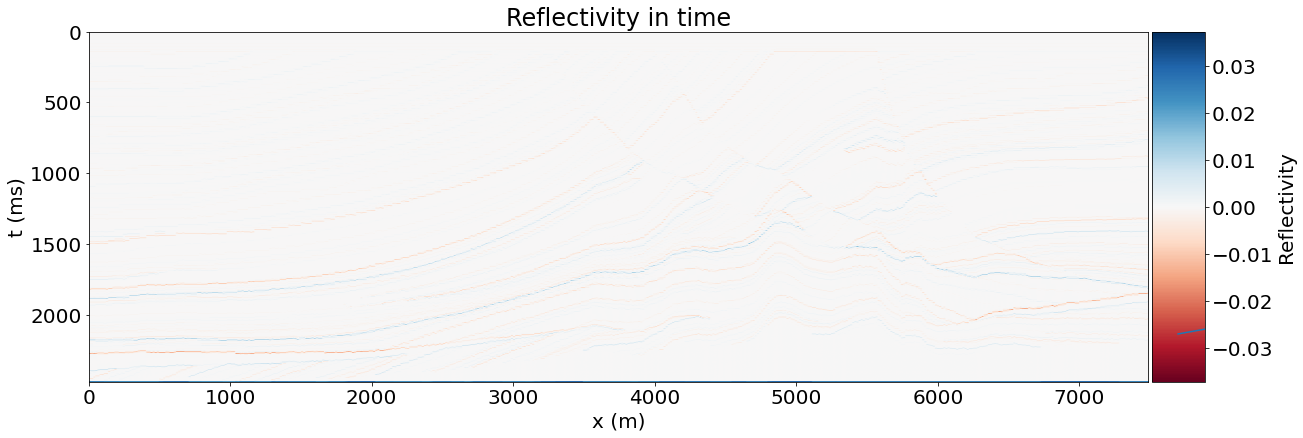

In [ ]:

plt.figure()
extent = [x[0], x[-1], 1000*time[-1], time[0]]
plot=plt.imshow(np.transpose(vel_time), extent=extent)
plt.xlabel('x (m)')
plt.ylabel('t (ms)')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot, cax=cax)
cbar.set_label(r'$V_{P}$ (km/s)')

# Make synthetic data in time

def diffmat(nt) :
    '''Returns the first derivative matrix and its adjoint (transpose)'''
    I = np.eye(nt)
    D = np.diff(I,axis=0)
    diff = np.zeros([nt,nt])
    diff[0:-1,:] = D
    return diff, np.transpose(diff)

### Calculate reflectivity (calculated here by just differentiating log of velocity)
### Replace velocity by product of velocity and density
deriv, _ = diffmat(vel_time.shape[1]) ### First derivative matrix
deriv = deriv/dz ### scale the matrix by stepsize in z
refl_time = np.matmul(np.log(vel_time), deriv)
plt.figure()
extent = [x[0], x[-1], 1000*time[-1], time[0]]
val = np.percentile(refl_time,99.9)
plot=plt.imshow(np.transpose(refl_time), extent=extent, vmax=val, vmin=-val, cmap='RdBu')
plt.xlabel('x (m)')
plt.ylabel('t (ms)')
plt.title('Reflectivity in time')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot, cax=cax)
cbar.set_label('Reflectivity')

plt.plot(refl_time[0,:].T)


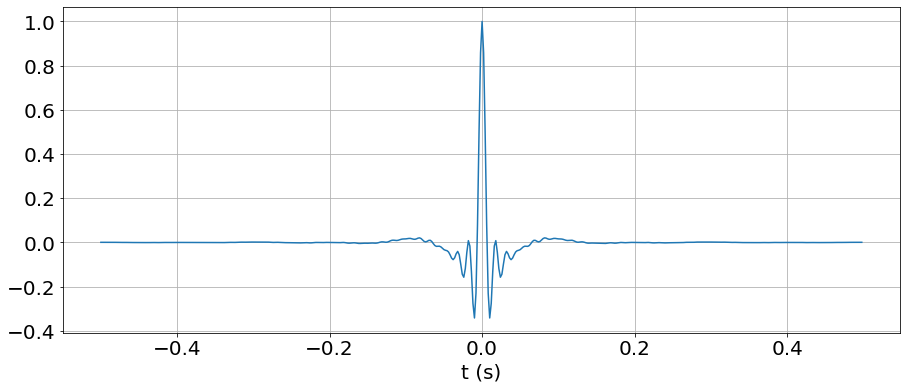

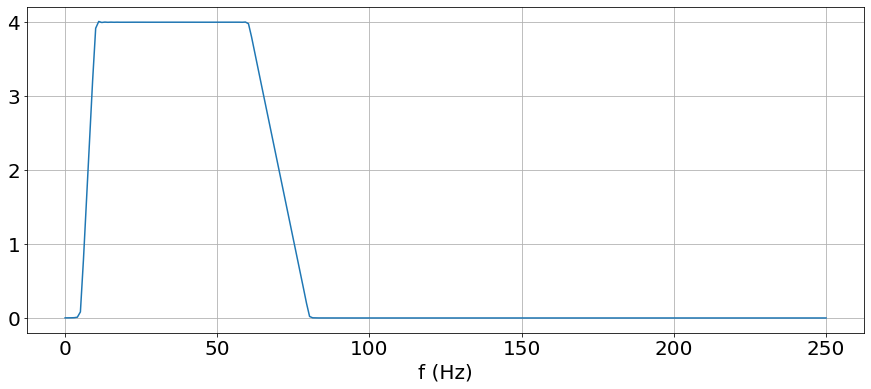

In [ ]:


from collections import namedtuple
import numpy as np
import scipy.signal
from scipy.fft import fft
def ormsby(duration, dt, f, return_t=False, return_f=False):
    """
    The Ormsby wavelet requires four frequencies which together define a
    trapezoid shape in the spectrum. The Ormsby wavelet has several sidelobes,
    unlike Ricker wavelets.
    Args:
        duration (float): The length in seconds of the wavelet.
        dt (float): The sample interval in seconds (usually 0.001, 0.002,
            or 0.004).
        f (ndarray): Sequence of form (f1, f2, f3, f4), or list of lists of
            frequencies, which will return a 2D wavelet bank.
    Returns:
        ndarray: A vector containing the Ormsby wavelet, or a bank of them.
    """
    f = np.asanyarray(f).reshape(-1, 1)

    try:
        f1, f2, f3, f4 = f
    except ValueError:
        raise ValueError("The last dimension must be 4")

    def numerator(f, t):
        return (np.sinc(f * t)**2) * ((np.pi * f) ** 2)

    pf43 = (np.pi * f4) - (np.pi * f3)
    pf21 = (np.pi * f2) - (np.pi * f1)

    t = np.arange(-duration/2, duration/2, dt)

    w = ((numerator(f4, t)/pf43) - (numerator(f3, t)/pf43) -
         (numerator(f2, t)/pf21) + (numerator(f1, t)/pf21))

    w = np.squeeze(w) / np.amax(w)
    freq=np.linspace(0,1/(2*dt),len(t)//2)
    wf=fft(w.flatten())
    wf=wf[0:len(freq)]

    if return_t and return_f:
        OrmsbyWavelet = namedtuple('OrmsbyWavelet', ['amplitude','fft', 'time','freq'])
        return OrmsbyWavelet(w,wf, t, freq)
    elif return_t:
        OrmsbyWavelet = namedtuple('OrmsbyWavelet', ['amplitude', 'time'])
        return OrmsbyWavelet(w, t)
    elif return_f:
        OrmsbyWavelet = namedtuple('OrmsbyWavelet', ['fft', 'freq'])
        return OrmsbyWavelet(wf, freq)
    else:
        return w


M=refl_time.shape[0]
f=[5,10,60,80]
#broadband wavelet
duration=M*dt
wavelet,wf,t,fr=ormsby(duration, dt, f, return_t=True,return_f=True)
plt.figure(figsize=(15,6))
plt.plot(t,wavelet)
plt.xlabel('t (s)')
plt.grid()
plt.figure(figsize=(15,6))
plt.plot(fr, np.abs(wf))
plt.xlabel('f (Hz)')
plt.grid()


(500,)

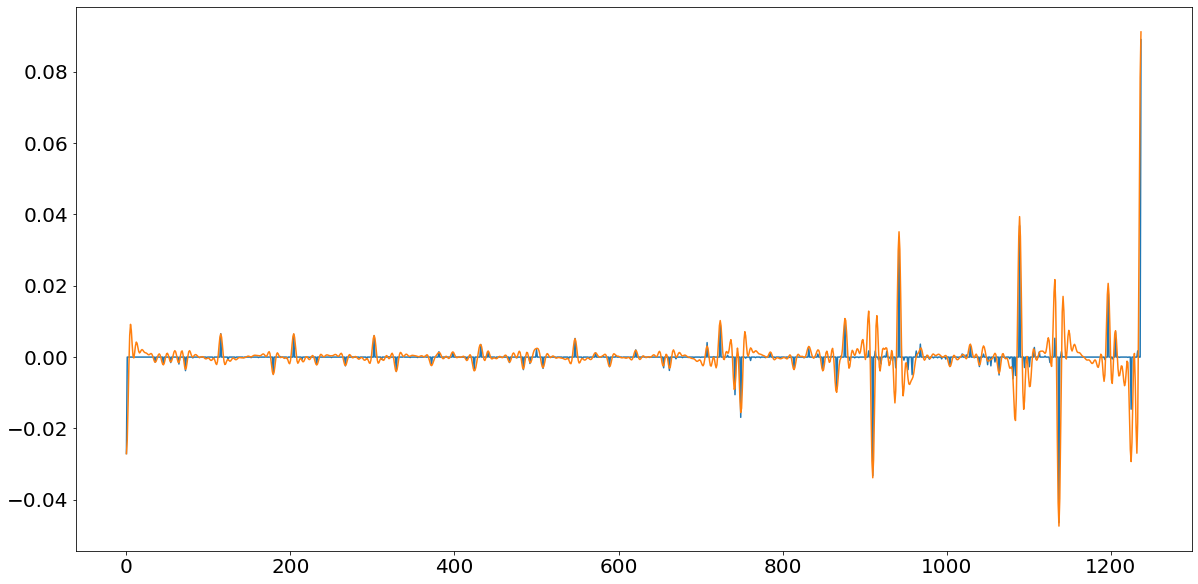

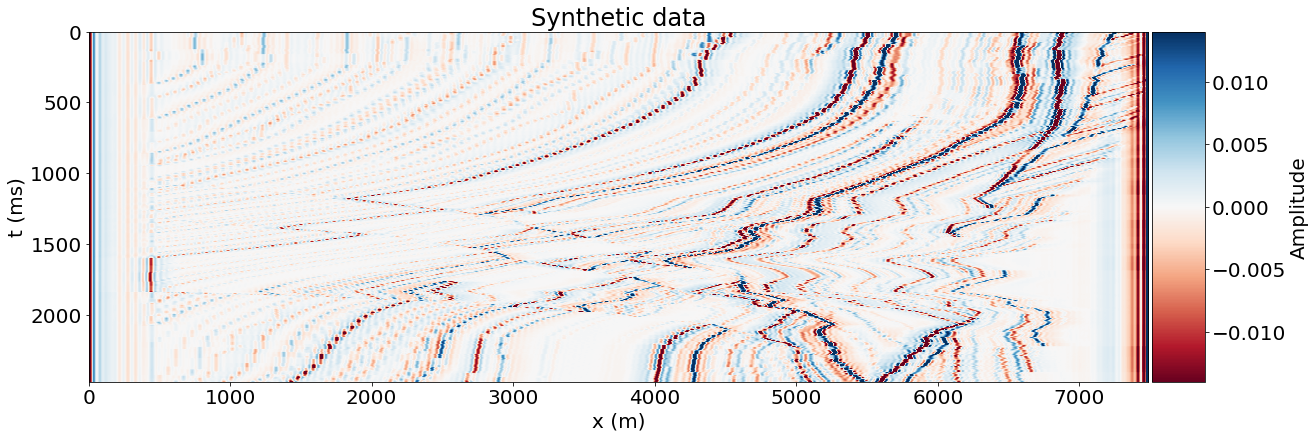

In [ ]:
def convz(wavelet, nt) :
    '''Returns the Topelitz matrix corresponding to CREWES style convz function'''
    aug_wav = np.zeros(2*nt)
    ind = nt-np.ceil(len(wavelet)/2).astype(np.int)
    aug_wav[ind:ind+len(wavelet)] = wavelet[:]
    W = scipy.linalg.toeplitz(aug_wav)
    Wconv = W[nt:2*nt,0:nt]
    return Wconv

W = convz(wavelet,refl_time.shape[1])
synth_data = np.matmul(W, np.transpose(refl_time))
synth_data.shape

def convz_python(r,w):

    nzero=int((len(w))/2)
    nout=len(r)


    if r.shape[0]==1:
         r=np.transpose(r)
    if w.shape[0]==0:
        w=w.flatten().reshape(-1,1)

    temp=np.convolve(r,w)
    s=temp[nzero:nout+nzero]

    if r.shape[0]==1:
         s=np.transpose(s)

    return s

s=[]
for i in range(refl_time.shape[0]):
    s.append(convz_python(refl_time[i,:],wavelet))
s=np.asarray(s)
s.shape

plt.plot(refl_time[0,:])
plt.plot(s[0,:])



plt.figure()
extent = [x[0], x[-1], 1000*time[-1], time[0]]
val = np.percentile(synth_data,99)
plot=plt.imshow(s, extent=extent, vmax=val, vmin=-val, cmap='RdBu')
plt.xlabel('x (m)')
plt.ylabel('t (ms)')
ax = plt.gca()
plt.title('Synthetic data')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(plot, cax=cax)
cbar.set_label('Amplitude')

plt.plot(refl_time[0,:])
plt.plot(synth_data[:,0])
synth_data.shape
wavelet.shape


In [ ]:
!pip install sporco

     |████████████████████████████████| 4.4MB 2.9MB/s 
     |████████████████████████████████| 2.6MB 29.5MB/s 


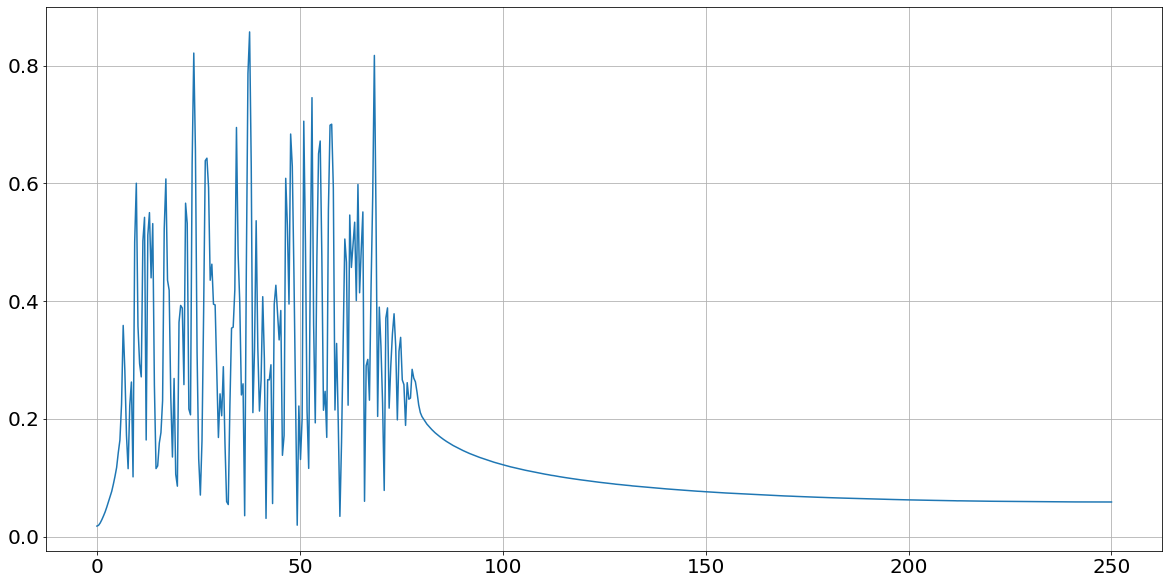

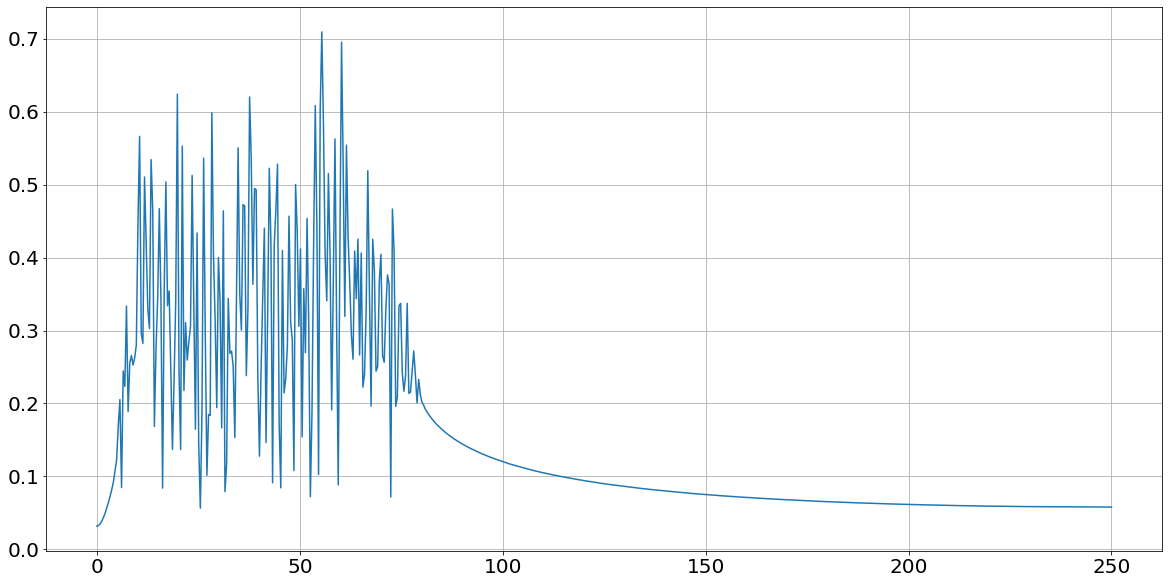

In [ ]:

def formW(M,N,wav,wav1=None,wav2=None,wav3=None,wav4=None):
#reflectivity series
    Re = np.zeros((M,N*M))
    Ro = np.zeros((M,N*M))
    flag = -1


    for m in range(M):
        for n in range(1,N+1,1):
            flag = flag+1
            Re[m][flag] = 1.0
            Ro[m][flag] = 1.0
            if m+n<M:
                Re[m+n][flag]=1.0
                Ro[m+n][flag]=-1.0

    for n in range(M*N-1,-1,-1):
            if np.sum(Re[:,n])!=2:
                Re= np.delete(Re,n,1)
            if np.sum(Ro[:,n])!=0:
                Ro=np.delete(Ro,n,1)

    #convolve with wavelet

    if wav1 is None and wav2 is None and wav3 is None and wav4 is None:
        W = np.zeros((M,2*Re.shape[1]))
        x=-1

        for i in range(0,W.shape[1],2):
                x=x+1
                W[:,i] = convz_python(Re[:,x],wav)
                W[:,i+1] = convz_python(Ro[:,x],wav)

        W=W

    elif wav2 is None and wav3 is None and wav4 is None:
        W = np.zeros((M,2*Re.shape[1]))
        W1 = np.zeros((M,2*Re.shape[1]))
        x=-1
        for i in range(0,W.shape[1],2):
            x=x+1
            W[:,i] = convz_python(Re[:,x],wav)
            W[:,i+1] = convz_python(Ro[:,x],wav)
            W1[:,i] = convz_python(Re[:,x],wav1)
            W1[:,i+1] = convz_python(Ro[:,x],wav1)

        W=np.append(W,W1,axis=1)
        Re=np.append(Re,Re,axis=1)
        Ro=np.append(Ro,Ro,axis=1)

    elif wav3 is None and wav4 is None:
        W = np.zeros((M,2*Re.shape[1]))
        W1 = np.zeros((M,2*Re.shape[1]))
        W2 = np.zeros((M,2*Re.shape[1]))


        x=-1

        for i in range(0,W.shape[1],2):
                x=x+1
                W[:,i] = convz_python(Re[:,x],wav)
                W[:,i+1] = convz_python(Ro[:,x],wav)
                W1[:,i] = convz_python(Re[:,x],wav1)
                W1[:,i+1] = convz_python(Ro[:,x],wav1)
                W2[:,i] = convz_python(Re[:,x],wav2)
                W2[:,i+1] = convz_python(Ro[:,x],wav2)

        W=np.append(np.append(W,W1,axis=1),W2,axis=1)
        Re=np.append((np.append(Re,Re,axis=1)),Re,axis=1)
        Ro=np.append((np.append(Ro,Ro,axis=1)),Ro,axis=1)


    elif wav4 is None:
        W = np.zeros((M,2*Re.shape[1]))
        W1 = np.zeros((M,2*Re.shape[1]))
        W2 = np.zeros((M,2*Re.shape[1]))
        W3 = np.zeros((M,2*Re.shape[1]))

        x=-1

        for i in range(0,W.shape[1],2):
                x=x+1
                W[:,i] = convz_python(Re[:,x],wav)
                W[:,i+1] = convz_python(Ro[:,x],wav)
                W1[:,i] = convz_python(Re[:,x],wav1)
                W1[:,i+1] = convz_python(Ro[:,x],wav1)
                W2[:,i] = convz_python(Re[:,x],wav2)
                W2[:,i+1] = convz_python(Ro[:,x],wav2)
                W3[:,i] = convz_python(Re[:,x],wav3)
                W3[:,i+1] = convz_python(Ro[:,x],wav3)

        W=np.append(np.append(W,W1,axis=1),np.append(W2,W3,axis=1),axis=1)
        Re=np.append((np.append(Re,Re,axis=1)),(np.append(Re,Re,axis=1)),axis=1)
        Ro=np.append((np.append(Ro,Ro,axis=1)),(np.append(Ro,Ro,axis=1)),axis=1)


    else:
        W = np.zeros((M,2*Re.shape[1]))
        W1 = np.zeros((M,2*Re.shape[1]))
        W2 = np.zeros((M,2*Re.shape[1]))
        W3 = np.zeros((M,2*Re.shape[1]))
        W4 = np.zeros((M,2*Re.shape[1]))


        x=-1

        for i in range(0,W.shape[1],2):
                x=x+1
                W[:,i] = convz_python(Re[:,x],wav)
                W[:,i+1] = convz_python(Ro[:,x],wav)
                W1[:,i] = convz_python(Re[:,x],wav1)
                W1[:,i+1] = convz_python(Ro[:,x],wav1)
                W2[:,i] = convz_python(Re[:,x],wav2)
                W2[:,i+1] = convz_python(Ro[:,x],wav2)
                W3[:,i] = convz_python(Re[:,x],wav3)
                W3[:,i+1] = convz_python(Ro[:,x],wav3)
                W4[:,i] = convz_python(Re[:,x],wav4)
                W4[:,i+1] = convz_python(Ro[:,x],wav4)

        W=np.append(np.append(W,W1,axis=1),np.append(W2,W3,axis=1),axis=1)
        W=np.append(W,W4,axis=1)
        Re=np.append((np.append(Re,Re,axis=1)),(np.append(np.append(Re,Re,axis=1),Re,axis=1)),axis=1)
        Ro=np.append((np.append(Ro,Ro,axis=1)),(np.append(np.append(Ro,Ro,axis=1),Ro,axis=1)),axis=1)


    return W,Re,Ro
# function that returns correlation coefficient.
def corrCoeff(X, Y) :
    import math
    n=len(X)
    sum_X = np.sum(X)
    sum_Y = np.sum(Y)
    sum_XY = np.sum(X*Y)
    squareSum_X = np.sum(X**2)
    squareSum_Y = np.sum(Y**2)

    coeff = (float)(n * sum_XY - sum_X * sum_Y)/(float)(math.sqrt((n * squareSum_X - sum_X * sum_X)*
                                                                  (n * squareSum_Y -sum_Y * sum_Y)))


    return coeff

def rms_err(x,y):
    return np.sqrt((x-y)**2)

from sporco.admm import bpdn
from sporco import util
from numpy import linalg as LA
from scipy.signal import correlate

def evalerr_norm(prm):
        print('Enter eval norm loop')
        lmbda = prm[0]
        print(lmbda)
        b = bpdn.BPDN(W, d, lmbda)
        x = b.solve()
        inv_r = np.matmul(Re,x[0:W.shape[1]:2]) + np.matmul(Ro,x[1:W.shape[1]:2])
        err = des - inv_r
        print(LA.norm(err,2))


        return LA.norm(err,2)

def evalerr_corr(prm):
    print('Enter eval corr loop')
    lmbda = prm[0]
    print(lmbda)
    b = bpdn.BPDN(W, d, lmbda)
    x = b.solve()
    inv_r = np.matmul(Re,x[0:W.shape[1]:2]) + np.matmul(Ro,x[1:W.shape[1]:2])

#         err = des - inv_r
    try:
        corr=corrCoeff(des,inv_r)
        #corr=np.max(correlate(des,inv_r,'valid'))

    except ZeroDivisionError:
        corr=0
    print(corr)
    return corr

def sparse_refl(W,Re,Ro,d,des=None,lamda=0.001,optimize=0):

#function that returns reflectivity given convolutional kernel, data and lambda
#  Function computing reconstruction error at lmbda

#     # Parallel evalution of error function on lmbda grid
        # return np.abs(acorr-corr)



    #print(des.shape)
    if optimize==1:
#         lrng = np.arange(lamda, 1,10**(-1))
#         print(lrng)
#         sprm, sfvl, fvmx, sidx = util.grid_search(evalerr_norm, (lrng,))
#         lmbda = sprm[0]
#         b = bpdn.BPDN(W, d, lmbda)
#         x = b.solve()
#         inv_r = np.matmul(Re,x[0:W.shape[1]:2]) + np.matmul(Ro,x[1:W.shape[1]:2])
# #         acorr=correlate(des,des,'valid')
#         #corr=np.max(correlate(des,inv_r,'valid'))
#         try:
#             corr=corrCoeff(des,inv_r)
#             #corr=np.max(correlate(des,inv_r,'valid'))
#         except ZeroDivisionError:
#             corr=0

#         if corr<0.8:
            lrng = np.arange(lamda, 1,10**(-1))
            print(lrng)
            sprm, sfvl, fvmx, sidx = util.grid_search(evalerr_corr, (lrng,),fmin=False)
            lmbda = sprm[0]
#         print(sprm)
#         print(fvmx)



    else:
        lmbda=lamda

    b = bpdn.BPDN(W, d, lmbda)
    x = b.solve()
    inv_r = np.matmul(Re,x[0:W.shape[1]:2]) + np.matmul(Ro,x[1:W.shape[1]:2])
    coeff=0
    if des is not None:
          coeff=corrCoeff(des,inv_r)
          print('Min L1 norm error is: {:.4f} and L2 norm error is {:.4f} and max error of any element is {:.4f}'.format(LA.norm(des-inv_r,1),LA.norm(des-inv_r,2),np.max(np.abs(des-inv_r))))



    res = np.matmul(W,x) - d
    sol={'x1norm':0,'x2norm':0,'r1norm':0,'r2norm':0}
    sol['x1norm'] = LA.norm(x,1)
    sol['x2norm'] = LA.norm(x,2)
    sol['r1norm'] = LA.norm(res,1)
    sol['r2norm'] = LA.norm(res,2)



    return x, b, sol,lmbda,inv_r,coeff

def plot_result(time_t,d,d_inv_r3,r,inv_r3,lamda,size=(14,7)):
    import matplotlib.pyplot as plt
    plt.figure(figsize=size)
    plt.plot(time_t,d,label='orig convolved data',color='b')
    plt.plot(time_t,d_inv_r3,label='inv convolved data',color='k')
    plt.legend()

    plt.figure(figsize=size)
    plt.plot(time_t,d,color='b')
    plt.title('orig convolved data')
    plt.ylabel('$t$ (s)')
    plt.xlabel('trace')
    plt.figure(figsize=size)
    plt.plot(time_t,d_inv_r3,color='k')
    plt.title('inv convolved data with $\lambda$={}'.format(lamda))
    plt.ylabel('$t$ (s)')
    plt.xlabel('trace')

    fig, ax = plt.subplots(figsize=size)

    # im = ax.pcolor(np.arange(0,r.shape[1],1),tobs,r)


    # Add a colorbar
    ax.plot(time_t,r,linewidth=1,linestyle='dashdot',label='Original Reflectivity', color='k')
    plt.gca()
    ax.set_ylabel('$t$ (s)')
    ax.set_xlabel('trace')



    # im = ax.pcolor(np.arange(0,r.shape[1],1),tobs,rec_r)

    # Add a colorbar

    # fig.colorbar(im, ax=ax)
    ax.plot(time_t,inv_r3,linewidth=1,linestyle='dashdot',label='Inverted Reflectivity', color='r')
    plt.gca()

    ax.set_ylabel('$t$ (s)')
    ax.set_xlabel('trace')
    ax.set_title('Inverted Vs Original Reflectivity')

    ax.legend()


    plt.figure(figsize=size)

    plt.plot(time_t,rms_err(r,inv_r3),linewidth=1,linestyle='dashdot',label='RMS error', color='b')

    plt.title('RMS error')
    plt.ylabel('$t$ (s)')
    plt.xlabel('trace')

    plt.figure(figsize=size)
    plt.plot(time_t,r,linewidth=1, color='k')
    plt.title('Orig Reflectivity Data')
    plt.ylabel('$t$ (s)')
    plt.xlabel('trace')

    plt.figure(figsize=size)
    plt.plot(time_t,inv_r3,linewidth=1, color='r')
    plt.title('Inverted Reflectivity Data')
    plt.ylabel('$t$ (s)')
    plt.xlabel('trace')

    from scipy.signal import correlate
    plt.figure(figsize=size)
    corr2=correlate(r,inv_r3,'same')
    plt.plot(time_t,corr2,'r')
    plt.title('Correlation between original and inverted reflectivity with $\lambda$={}'.format(lamda))

    plt.show()



def plot_fft(r,dt):
  from scipy.fft import fft
# Number of sample points
  N = len(r)
  # sample spacing
  T = dt
  # x = np.linspace(0.0, N*T, N)
  # y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
  yf = fft(r.flatten())
  xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
  import matplotlib.pyplot as plt
  plt.plot(xf, np.abs(yf[0:N//2]))
  plt.grid()
  plt.show()

plot_fft(s[0,:],dt)
plot_fft(s[-1,:],dt)


s.shape
def ricker_wave(fm,ts,s,e):
    t=np.arange(-(e-s)/2,(e-s)/2,ts)
    f=np.linspace(0,1/(2*ts),len(t))
    r_t=(1-2*(np.pi**2*fm**2*t**2))*np.exp(-1*np.pi**2*fm**2*t**2)

    r_f=2*f**2*np.exp(-1*f**2/fm**2)/(np.pi**(1/2)*fm**3)

    t=t+(e-s)/2
    return r_t,r_f,t,f


In [ ]:
r=refl_time.T
s_new=s.T
M=len(r)
tr_no=5
tr_ind=np.random.randint(0,len(refl_time),size=tr_no)

fm_s=2
fm_e=102

step=int((fm_e-fm_s)/5)
fm=fm_s
fm1=fm+step
fm2=fm1+step
fm3=fm2+step
fm4=fm3+step
dt =2*10**(-3)
fs=1/dt
tlength = (M)*dt

wav,wavf, tw, fw = ricker_wave(fm,dt,0,tlength)
wav=wav/np.max(np.abs(wav))

wav1, wavf1, tw1, fw1 = ricker_wave(fm1,dt,0,tlength)
wav1 = wav1/np.max(np.abs(wav1))

wav2, wavf2, tw2, fw2 = ricker_wave(fm2,dt,0,tlength)
wav2 = wav2/np.max(np.abs(wav2))

wav3, wavf3, tw3, fw3 = ricker_wave(fm3,dt,0,tlength)
wav3 = wav3/np.max(np.abs(wav3))

wav4, wavf4, tw4, fw4 = ricker_wave(fm4,dt,0,tlength)
wav4 = wav4/np.max(np.abs(wav4))

N=10
rec_r=np.zeros(r.shape)
d_inv=np.zeros(rec_r.shape)



W, Re, Ro = formW(M,N,wav,wav1,wav2,wav3,wav4)



[0.001 0.101 0.201 0.301 0.401 0.501 0.601 0.701 0.801 0.901]
Enter eval corr loop
0.001
Enter eval corr loop
0.201
0.8405764353070775
Enter eval corr loop
0.101
0.5697061903935839
Enter eval corr loop
0.30100000000000005
0.5697061903935839
Enter eval corr loop
0.401
0.6060427692620761
Enter eval corr loop
0.6010000000000001
0.569706190393584
Enter eval corr loop
0.501
0
Enter eval corr loop
0.7010000000000001
0
Enter eval corr loop
0.801
0
0
Enter eval corr loop
0.901
0
Min L1 norm error is: 0.6025 and L2 norm error is 0.0596 and max error of any element is 0.0312
Lambda optimized for column 366 is : 0.001


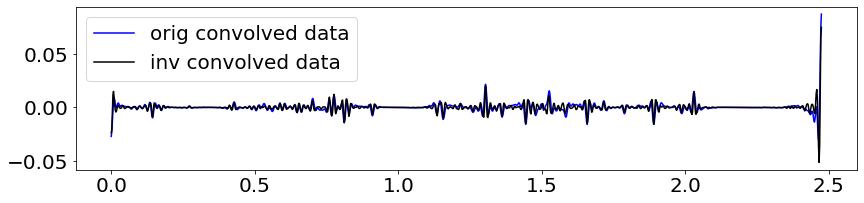

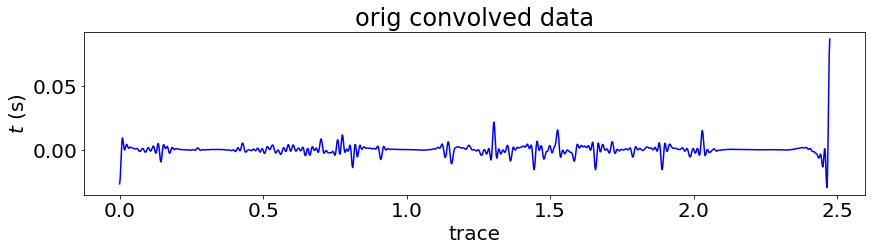

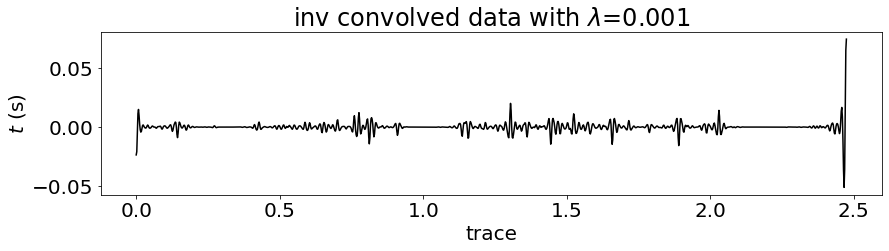

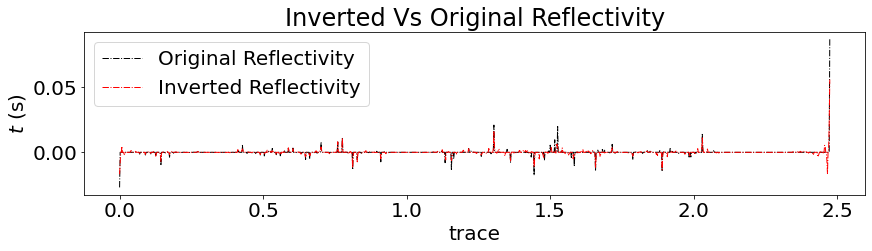

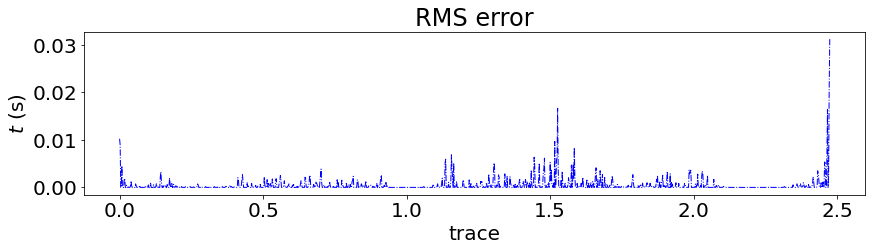

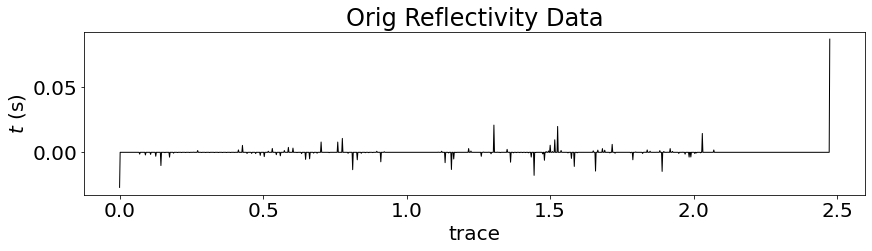

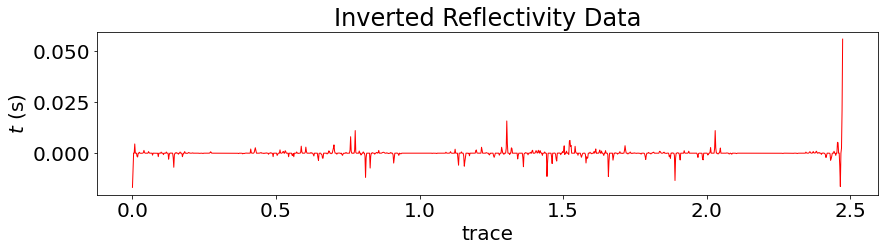

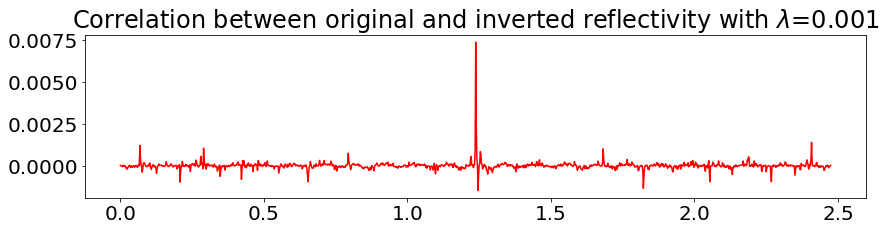

[0.001 0.101 0.201 0.301 0.401 0.501 0.601 0.701 0.801 0.901]
Enter eval corr loop
Enter eval corr loop
0.001
0.201
0.8195105650468154
Enter eval corr loop
0.101
0.5548605149953147
Enter eval corr loop
0.30100000000000005
0.5544725580996686
Enter eval corr loop
0.401
0.6072490925800763
Enter eval corr loop
0.6010000000000001
0.5544725580996686
Enter eval corr loop
0.501
0
Enter eval corr loop
0.7010000000000001
0
Enter eval corr loop
0.801
0
0
Enter eval corr loop
0.901
0
Min L1 norm error is: 0.6732 and L2 norm error is 0.0663 and max error of any element is 0.0319
Lambda optimized for column 492 is : 0.001


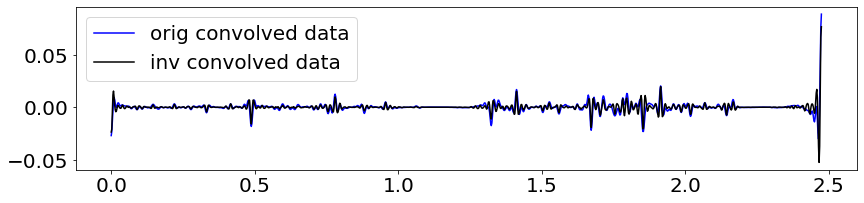

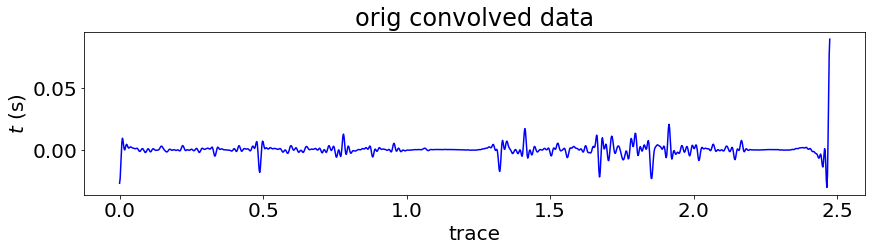

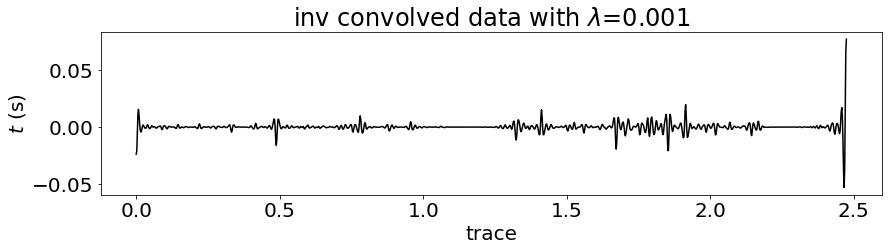

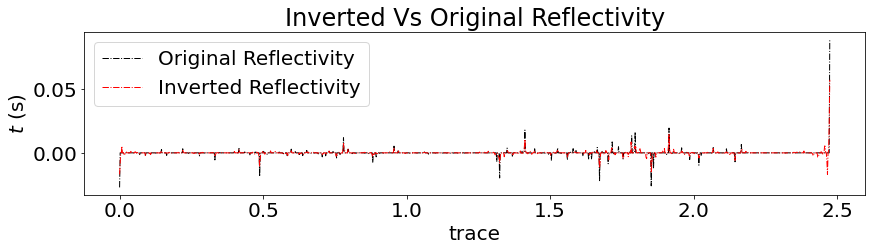

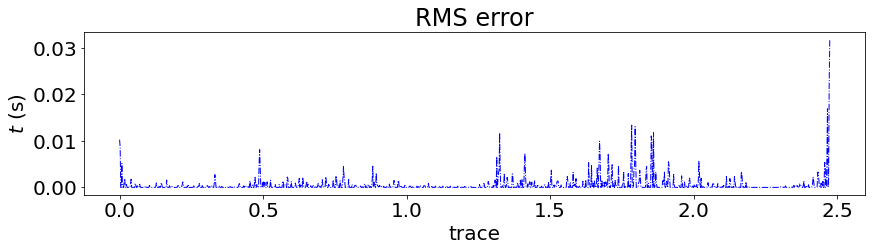

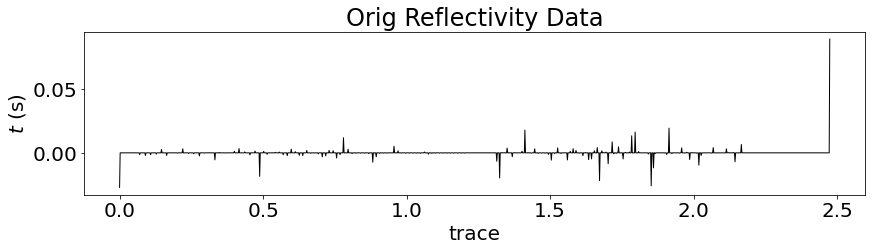

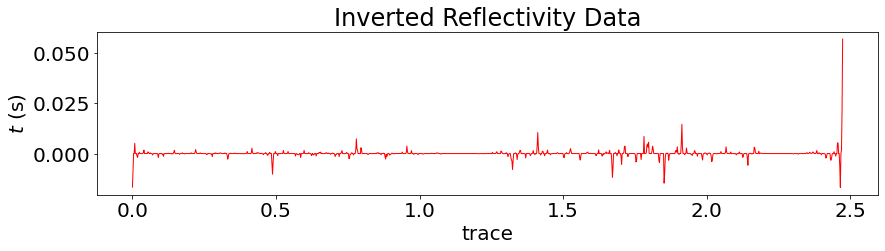

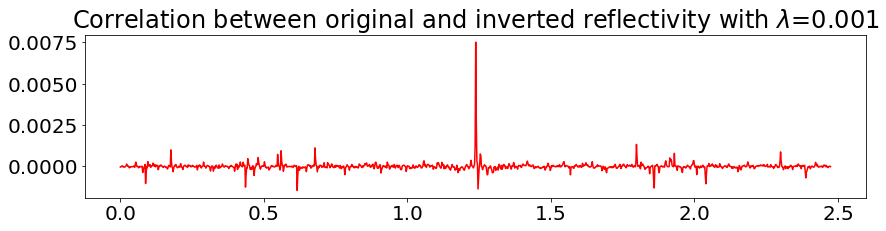

[0.001 0.101 0.201 0.301 0.401 0.501 0.601 0.701 0.801 0.901]
Enter eval corr loop
Enter eval corr loop
0.001
0.201
0.865753885097777
Enter eval corr loop
0.101
0.6050531542076504
Enter eval corr loop
0.30100000000000005
0.5837467272312479
Enter eval corr loop
0.401
0.6696661635374307
Enter eval corr loop
0.6010000000000001
0.5497179781493344
Enter eval corr loop
0.501
0
Enter eval corr loop
0.7010000000000001
0
Enter eval corr loop
0.801
0
0
Enter eval corr loop
0.901
0
Min L1 norm error is: 0.5907 and L2 norm error is 0.0613 and max error of any element is 0.0330
Lambda optimized for column 289 is : 0.001


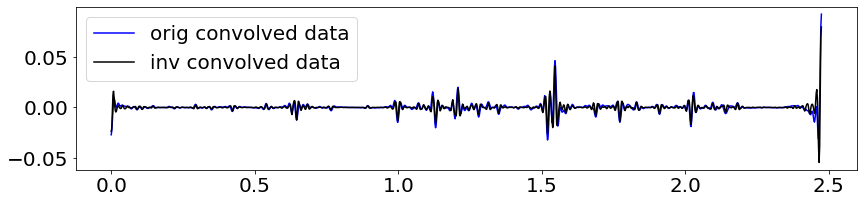

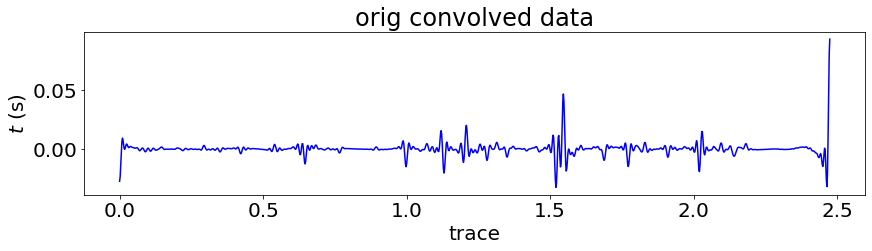

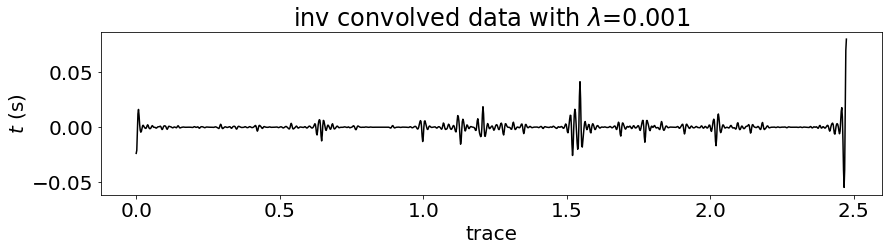

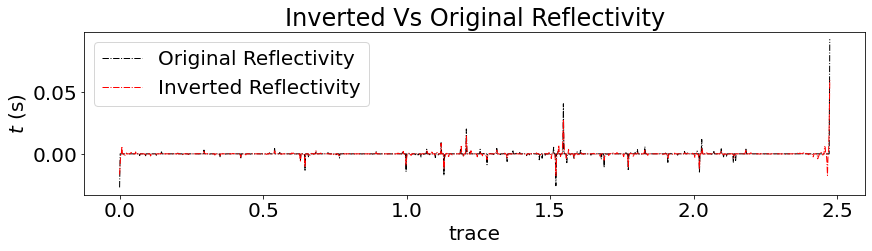

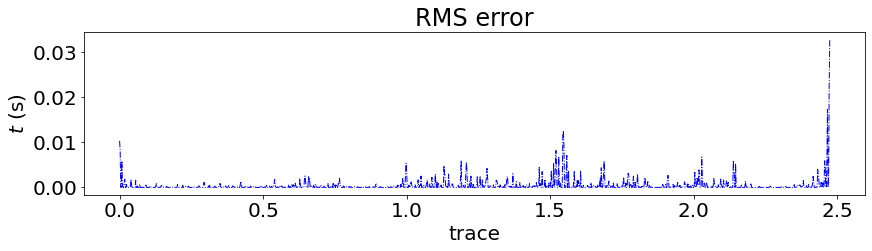

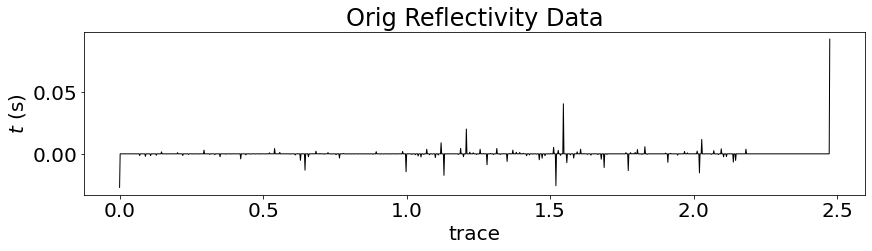

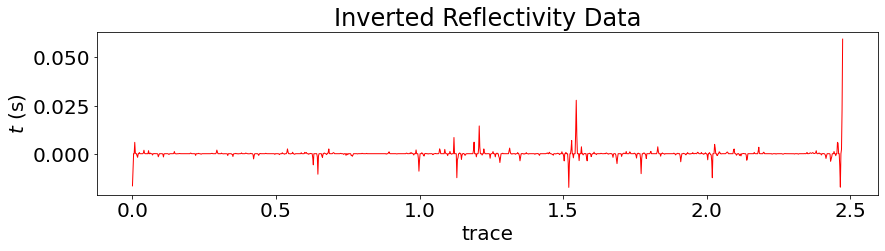

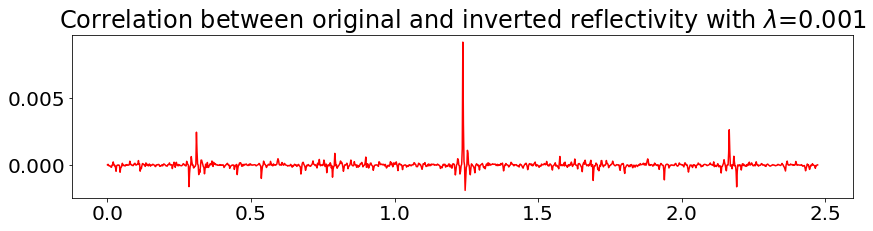

[0.001 0.101 0.201 0.301 0.401 0.501 0.601 0.701 0.801 0.901]
Enter eval corr loop
Enter eval corr loop
0.001
0.201
0.8535511953958598
Enter eval corr loop
0.101
0.6196226574288122
Enter eval corr loop
0.30100000000000005
0.6486912993642379
Enter eval corr loop
0.401
0.6196226574288122
Enter eval corr loop
0.6010000000000001
0.6196226574288122
Enter eval corr loop
0.501
0
Enter eval corr loop
0.7010000000000001
0
Enter eval corr loop
0.801
0
0
Enter eval corr loop
0.901
0
Min L1 norm error is: 0.5408 and L2 norm error is 0.0627 and max error of any element is 0.0363
Lambda optimized for column 325 is : 0.001


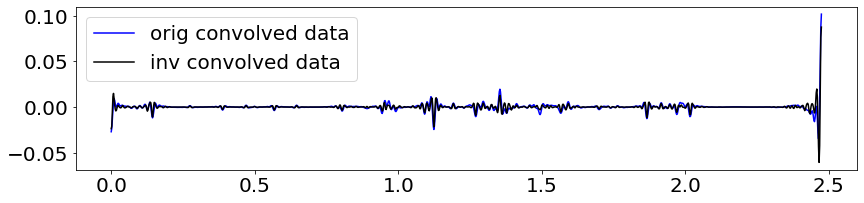

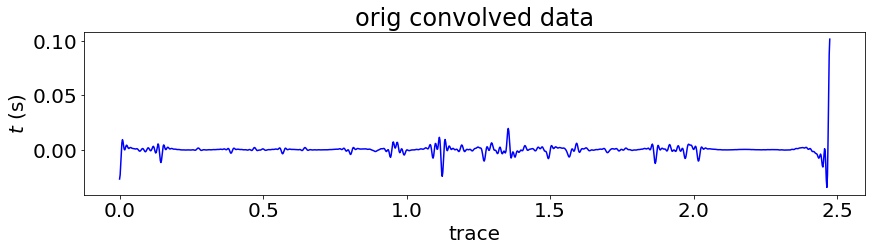

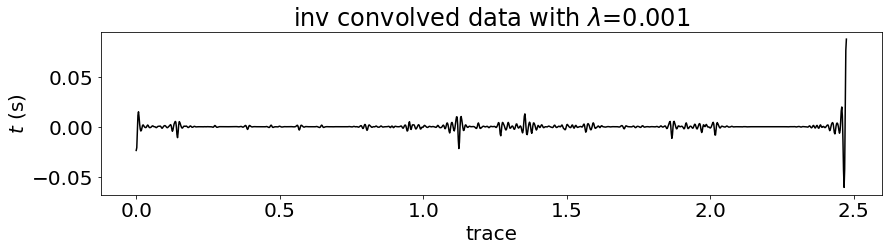

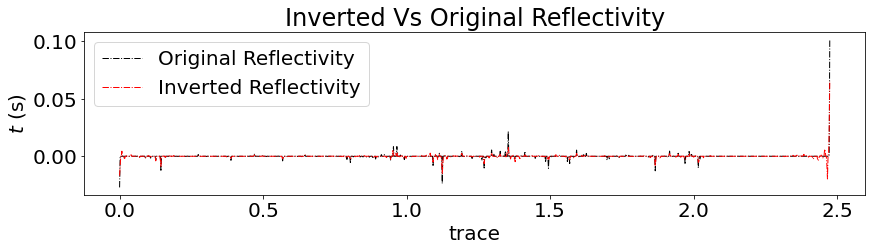

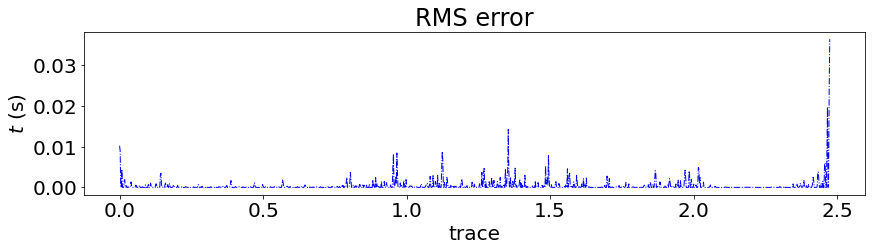

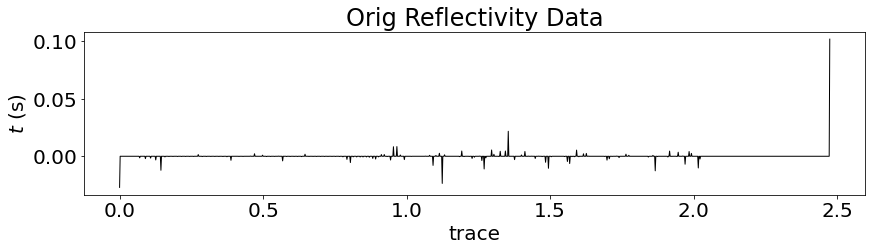

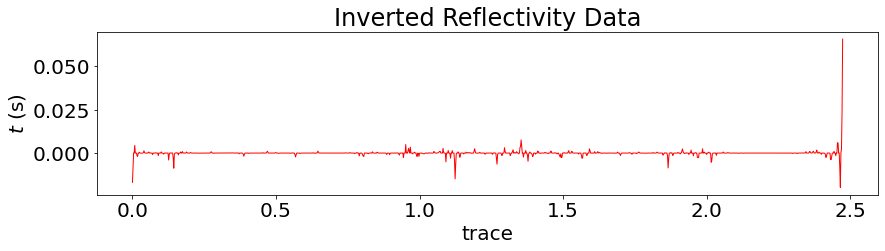

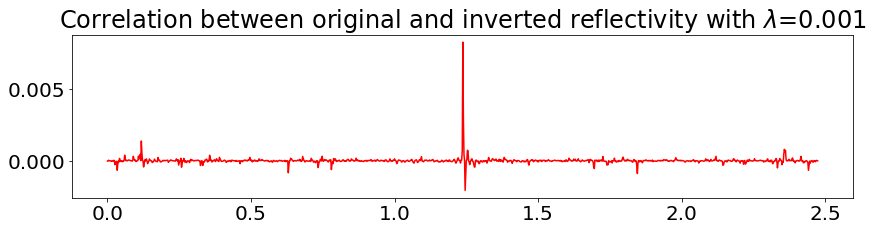

[0.001 0.101 0.201 0.301 0.401 0.501 0.601 0.701 0.801 0.901]
Enter eval corr loop
Enter eval corr loop
0.001
0.201
0.8557060243950951
Enter eval corr loop
0.101
0.5905456519910897
Enter eval corr loop
0.30100000000000005
0.5551622369013361
Enter eval corr loop
0.401
0.6555564301179668
Enter eval corr loop
0.6010000000000001
0.5545791487935684
Enter eval corr loop
0.501
0
Enter eval corr loop
0.7010000000000001
0
Enter eval corr loop
0.801
0
0
Enter eval corr loop
0.901


In [ ]:
time_t=dt*np.linspace(0,(len(s_new)-1),len(s_new))
lamda=10**(-3)
coeff5=[]
l_final=[]

for i in range(len(tr_ind)):
    d=s_new[:,tr_ind[i]].reshape(-1,1)
    des=r[:,tr_ind[i]].reshape(-1,1)
    x5, b5, sol5, l_final5,inv_r5,c5 = sparse_refl(W,Re,Ro,d,des,lamda,optimize=1)
    print('Lambda optimized for column {} is : {}'.format((tr_ind[i]),l_final5))
    rec_r[:,i:i+1:1] = inv_r5
    coeff5.append(c5)
    l_final.append(l_final5)
    d_inv[:,i] = convz_python(rec_r[:,i],wav3)
    plot_result(time_t,s_new[:,tr_ind[i]],d_inv[:,i],r[:,tr_ind[i]],rec_r[:,i],l_final5,(14,3))

In [ ]:
time_t=dt*np.linspace(0,(len(s_new)-1),len(s_new))
lamda=10**(-3)
coeff5=[]
l_final=[]

for i in range(len(tr_ind)):
    d=s_new[:,tr_ind[i]].reshape(-1,1)
    des=r[:,tr_ind[i]].reshape(-1,1)
    x5, b5, sol5, l_final5,inv_r5,c5 = sparse_refl(W,Re,Ro,d,des,lamda,optimize=1)
    print('Lambda optimized for column {} is : {}'.format((tr_ind[i]),l_final5))
    rec_r[:,i:i+1:1] = inv_r5
    coeff5.append(c5)
    l_final.append(l_final5)
    d_inv[:,i] = convz_python(rec_r[:,i],wav3)
    plot_result(time_t,s_new[:,tr_ind[i]],d_inv[:,i],r[:,tr_ind[i]],rec_r[:,i],l_final5,(14,3))

[0.001 0.101 0.201 0.301 0.401 0.501 0.601 0.701 0.801 0.901]
Enter eval corr loop
Enter eval corr loop
0.001
0.201
0.8604884483276398
Enter eval corr loop
0.101
0.6189658499551267
Enter eval corr loop
0.30100000000000005
0.555709024249664
Enter eval corr loop
0.401
0.6798082070367483
Enter eval corr loop
0.6010000000000001
0.49343239537275724
Enter eval corr loop
0.501
0
Enter eval corr loop
0.7010000000000001
0
Enter eval corr loop
0.801
0
0
Enter eval corr loop
0.901


30

Ouputs formed without optimization in Kaggle

Min L1 norm error is: 0.6388 and L2 norm error is 0.0628 and max error of any element is 0.0321
Lambda optimized for column 1 is : 1e-06


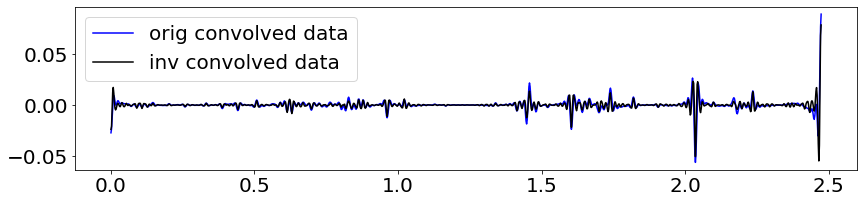

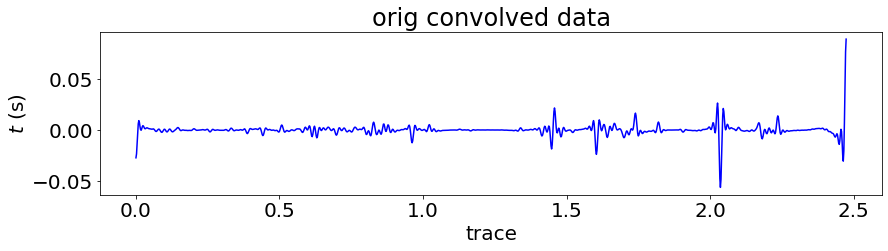

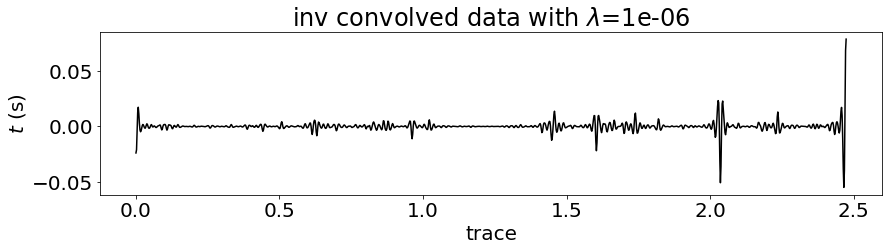

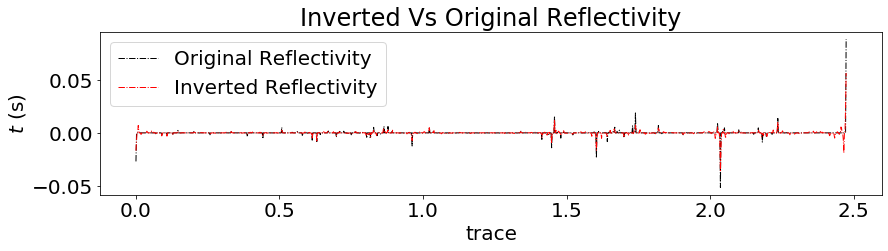

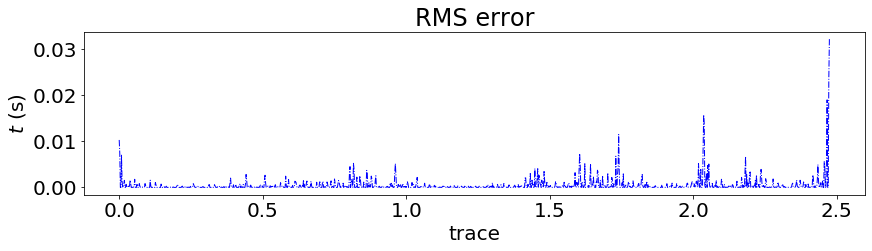

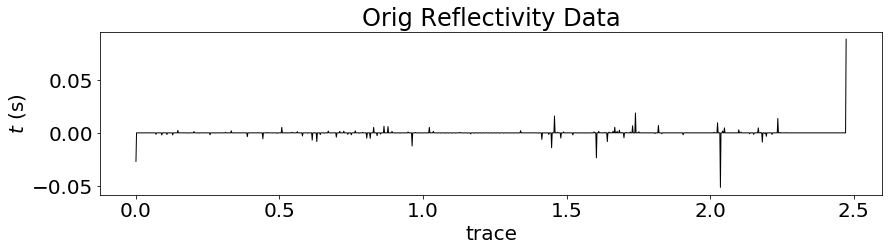

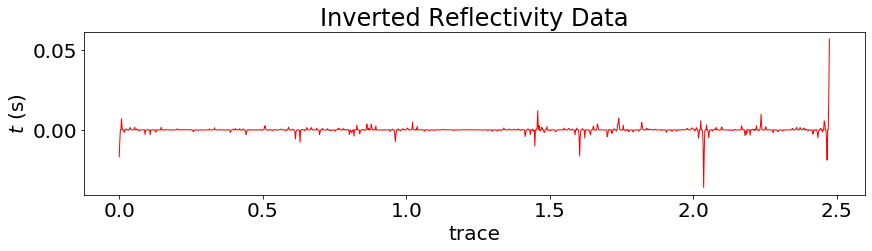

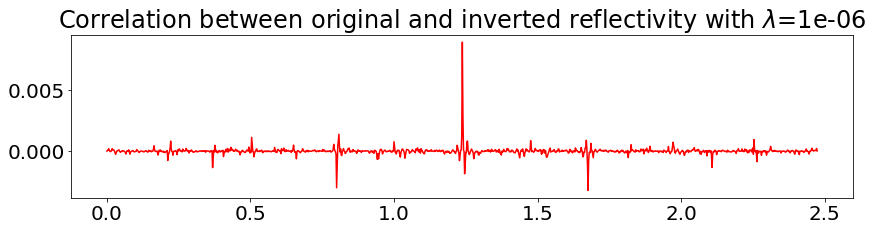

Min L1 norm error is: 0.5704 and L2 norm error is 0.0578 and max error of any element is 0.0313
Lambda optimized for column 2 is : 1e-06


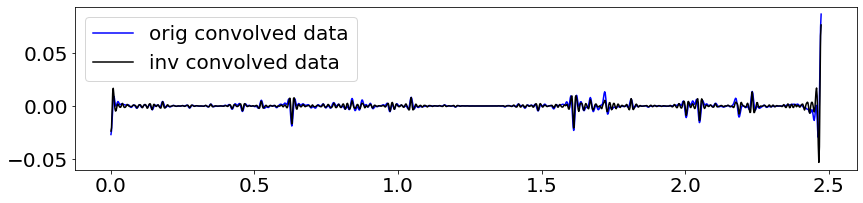

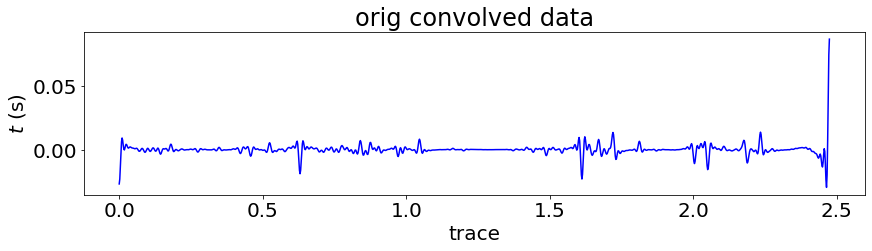

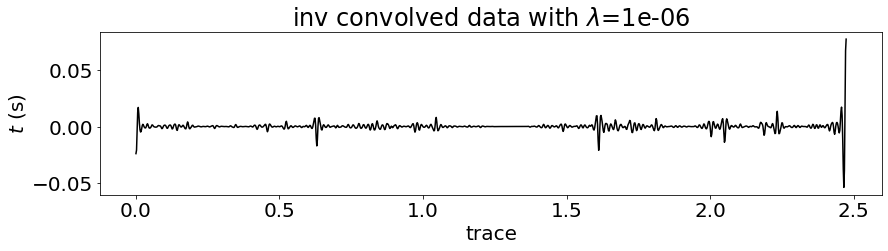

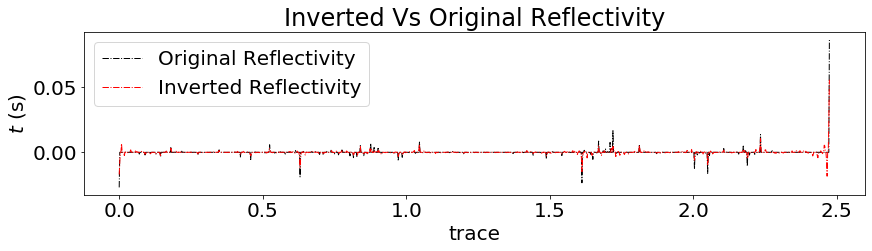

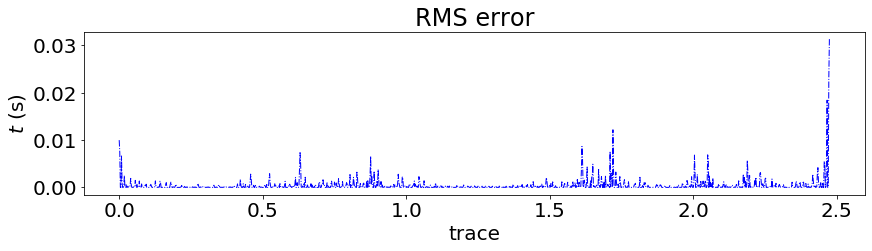

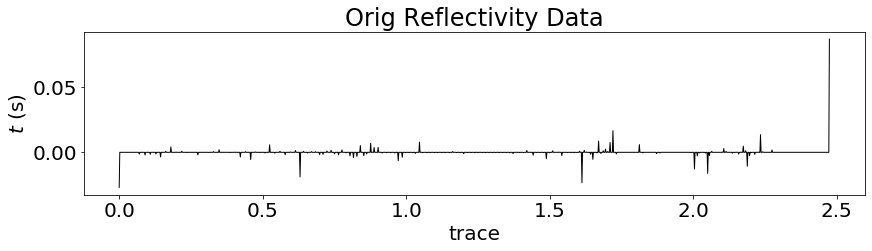

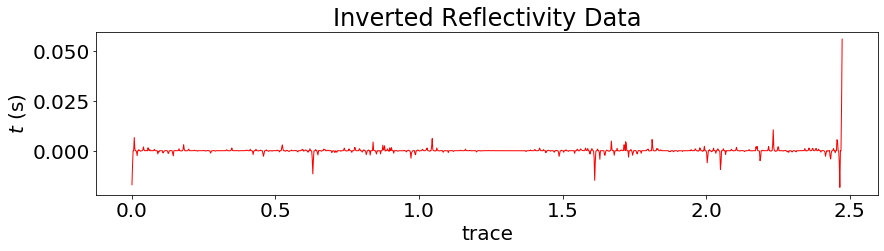

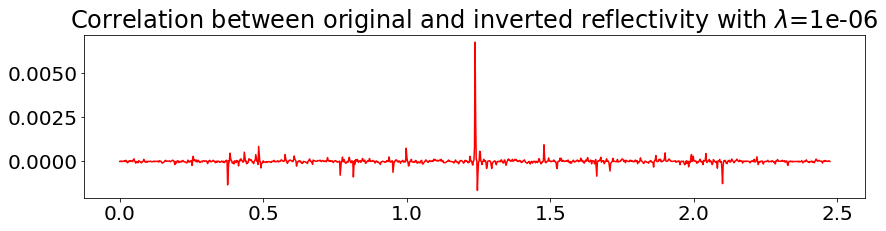

Min L1 norm error is: 0.6795 and L2 norm error is 0.0657 and max error of any element is 0.0296
Lambda optimized for column 3 is : 1e-06


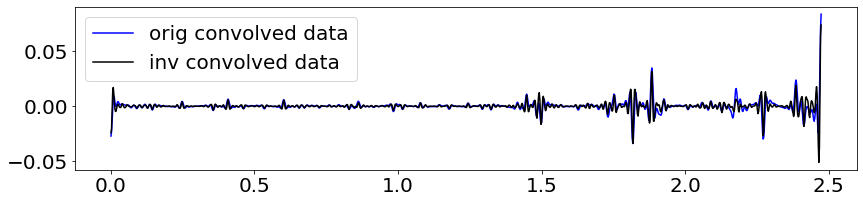

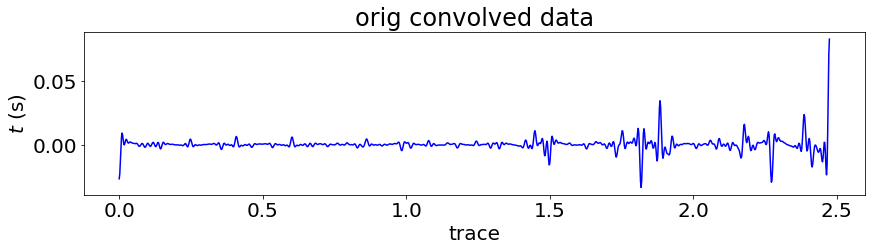

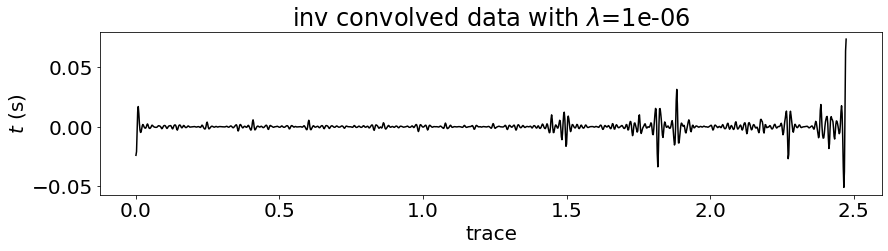

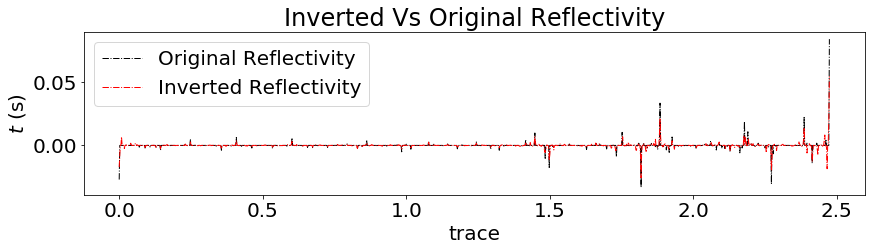

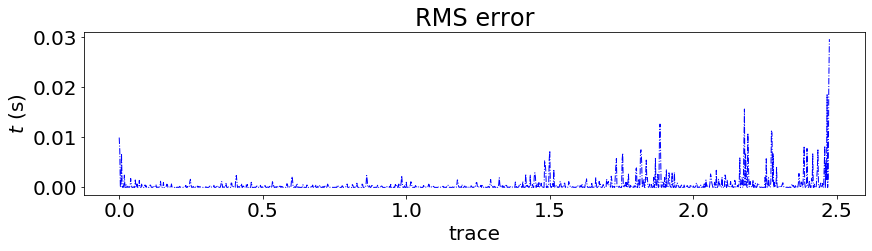

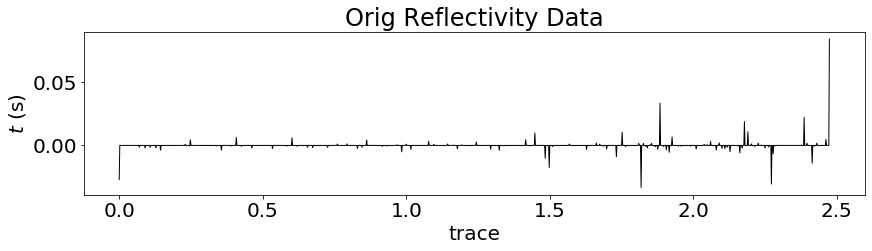

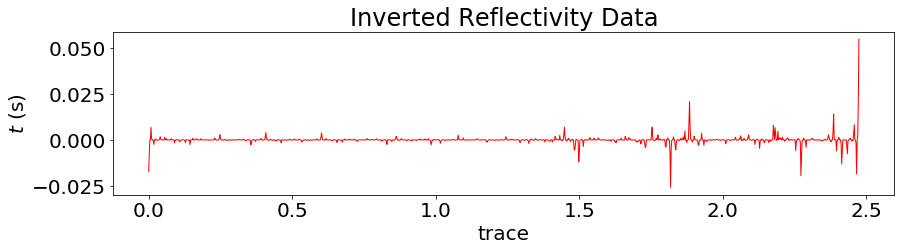

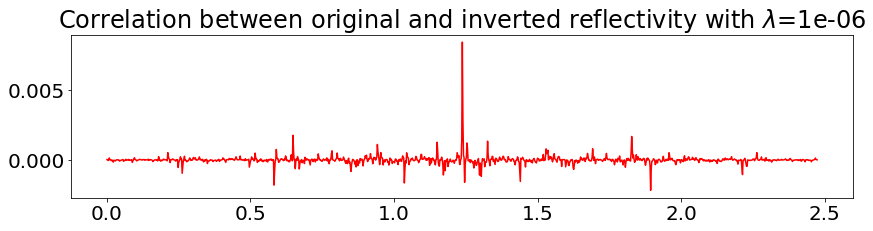

Min L1 norm error is: 0.7050 and L2 norm error is 0.0643 and max error of any element is 0.0315
Lambda optimized for column 4 is : 1e-06


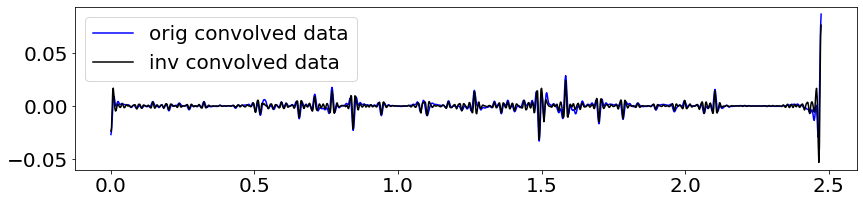

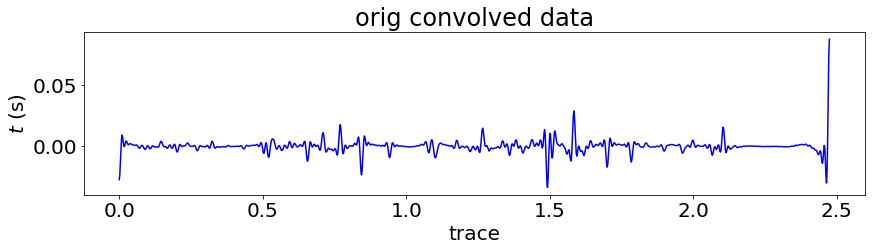

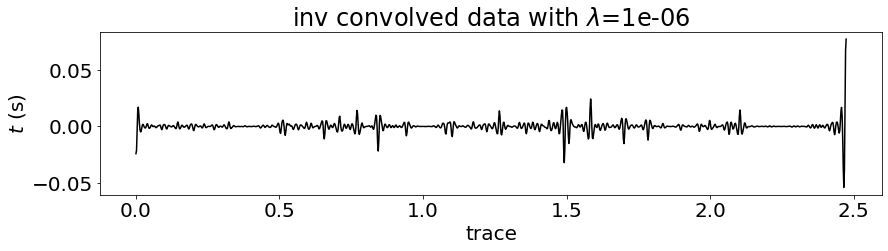

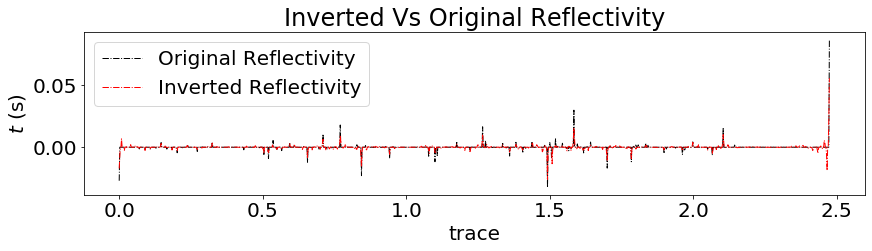

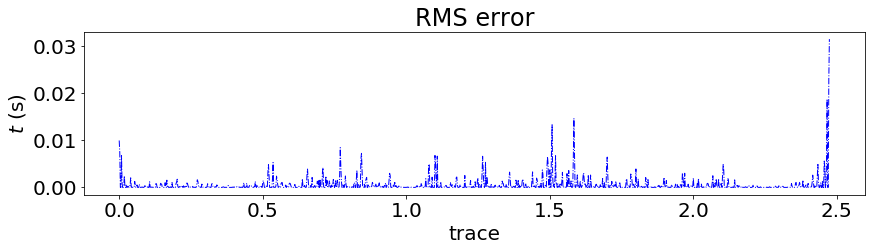

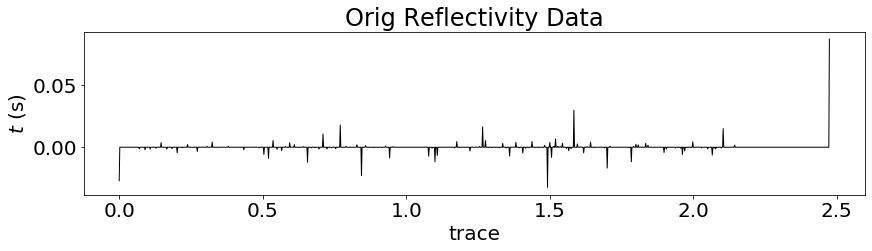

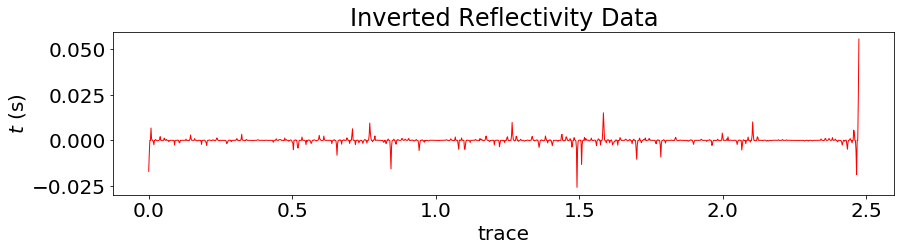

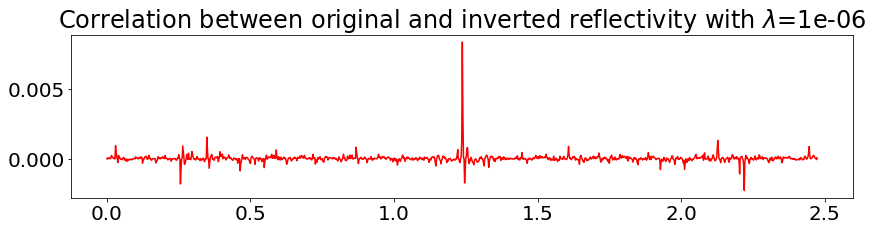

Min L1 norm error is: 0.6860 and L2 norm error is 0.0629 and max error of any element is 0.0302
Lambda optimized for column 5 is : 1e-06


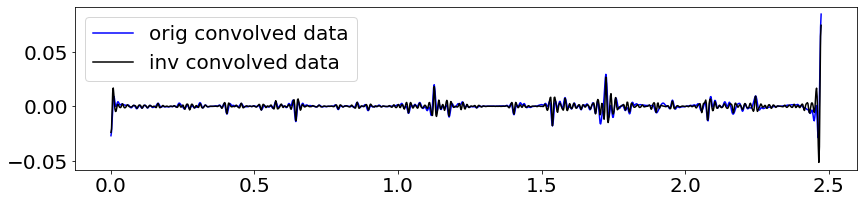

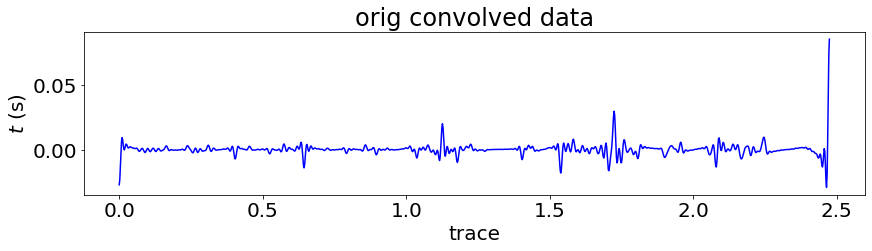

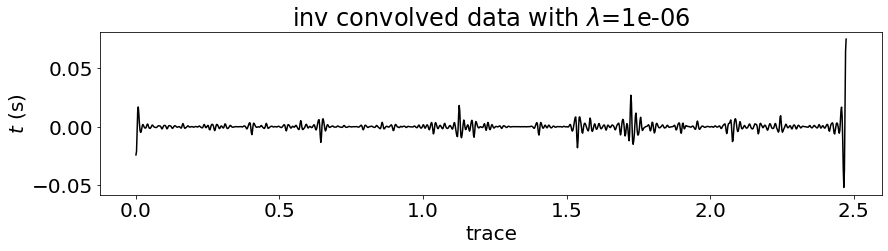

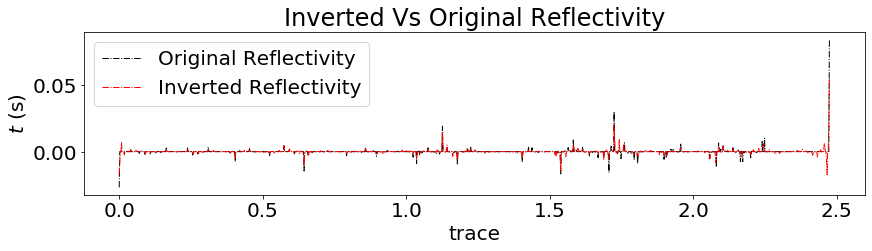

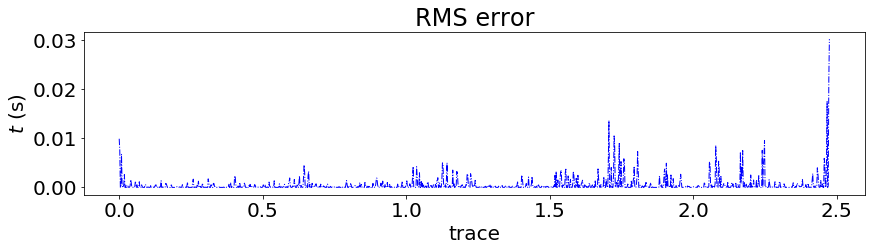

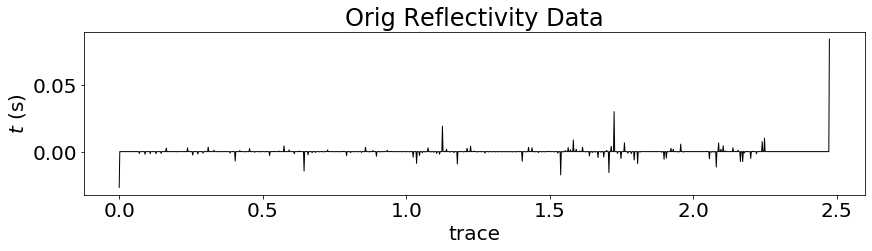

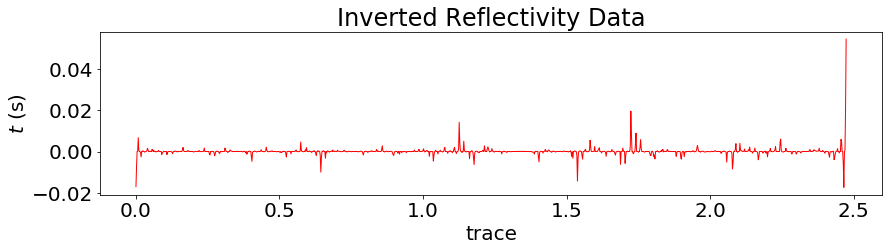

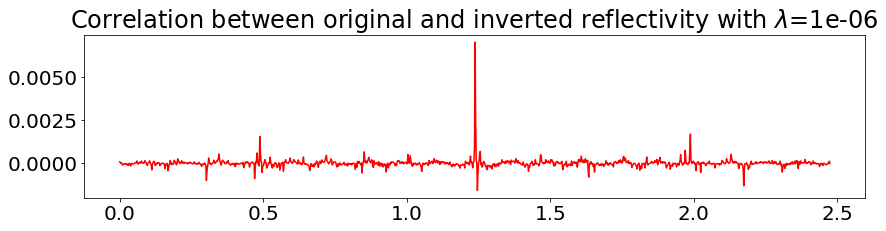

In [ ]:
time_t=dt*np.linspace(0,(len(s_new)-1),len(s_new))

coeff5=[]
l_final=[]

for i in range(len(tr_ind)):
    d=s_new[:,tr_ind[i]].reshape(-1,1)
    des=r[:,tr_ind[i]].reshape(-1,1)
    x5, b5, sol5, l_final5,inv_r5,c5 = sparse_refl(W,Re,Ro,d,des,lamda,optimize=0)
    print('Lambda optimized for column {} is : {}'.format((tr_ind[i]),l_final5))
    rec_r[:,i:i+1:1] = inv_r5
    coeff5.append(c5)
    l_final.append(l_final5)
    d_inv[:,i] = convz_python(rec_r[:,i],wav3)
    plot_result(time_t,s_new[:,tr_ind[i]],d_inv[:,i],r[:,tr_ind[i]],rec_r[:,i],l_final5,(14,3))

In [ ]:
for i in range(10):
    d=s_new[:,i].reshape(-1,1)
#     des=r[:,tr_ind[i]].reshape(-1,1)
    x5, b5, sol5, l_final5,inv_r5,c5 = sparse_refl(W,Re,Ro,d,des,lamda=0.2,optimize=0)
    print('Lambda optimized for column {} is : {}'.format((tr_ind[i]),l_final5))
    rec_r[:,i:i+1:1] = inv_r5
#     coeff5.append(c5)
#     l_final.append(l_final5)
    d_inv[:,i] = convz_python(rec_r[:,i],wav3)

Min L1 norm error is: 1.1079 and L2 norm error is 0.1052 and max error of any element is 0.0327


KeyboardInterrupt: 

In [ ]:
plt.imshow(rec_r.T)